In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np


In [2]:
df = pd.read_csv('../data/uppsala_tm_1722-2022/uppsala_tm_1722-2022.dat',sep=r'\s+',)
df.columns=['year','month','day','temp','temp_corrected','data_source']

In [3]:
df

,year,month,day,temp,temp_corrected,data_source
0,1722,1,13,2.3,2.2,1
1,1722,1,14,1.8,1.7,1
2,1722,1,15,0.9,0.8,1
3,1722,1,16,-1.8,-1.9,1
4,1722,1,17,0.5,0.4,1
...,...,...,...,...,...,...
109921,2022,12,27,0.1,-0.2,1
109922,2022,12,28,-4.1,-4.4,1
109923,2022,12,29,2.8,2.6,1
109924,2022,12,30,4.2,4.0,1


In [4]:
monthly_temp = df.groupby(['year', 'month'])['temp'].mean()


<Axes: title={'center': 'Daily Mean Temperature'}, xlabel='year,month'>

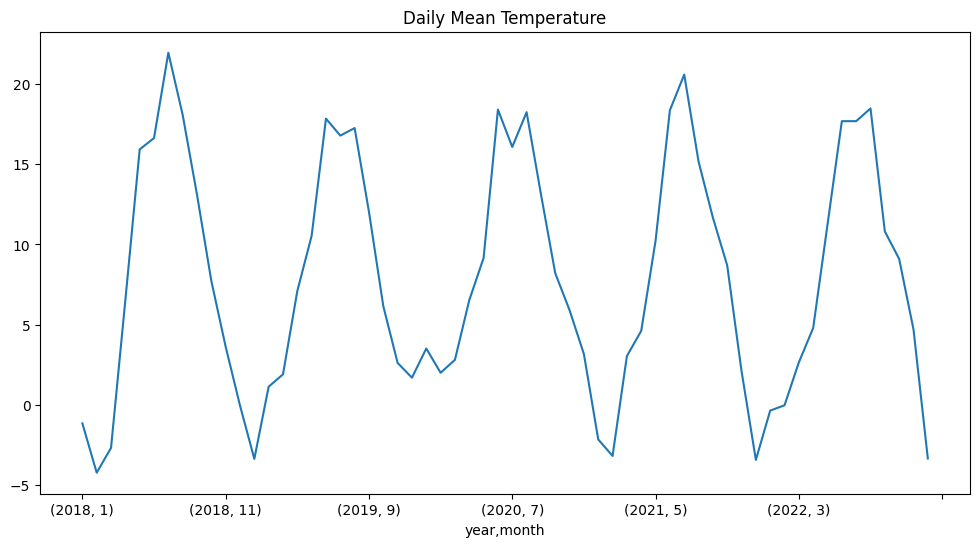

In [5]:
monthly_temp[-5*12:].plot(figsize=(12, 6), title='Daily Mean Temperature')


In [6]:
## Set up a dictionary for the specification of our priors
## We set up the dictionary to specify size of the AR coefficients in
## case we want to vary the AR lags.
lags = 2
priors = {
    "coefs": {"mu": [0 for i in range(lags)], "sigma": [1 for i in range(lags)], "size": lags},
    "sigma": 2,
    "init": {"mu": 5, "sigma": 2, "size": 1},
}
train = monthly_temp[:-48].copy()
test = monthly_temp[-48:].copy()
## Initialise the model
with pm.Model() as AR:
    pass

## Define the time interval for fitting the data
t_data_train = np.arange(train.index.shape[0])
t_data_test = np.arange(train.index.shape[0],train.index.shape[0] + test.index.shape[0])
## Add the time interval as a mutable coordinate to the model to allow for future predictions
AR.add_coord("obs_id", t_data_train)

with AR:
    ## Data containers to enable prediction
    t = pm.Data("t", t_data_train, dims="obs_id")
    y = pm.Data("y", train, dims="obs_id")

    # The first coefficient will be the constant term but we need to set priors for each coefficient in the AR process
    coefs = pm.Normal("coefs", priors["coefs"]["mu"], priors["coefs"]["sigma"])
    sigma = pm.HalfNormal("sigma", priors["sigma"])
    # We need one init variable for each lag, hence size is variable too
    init = pm.Normal.dist(
        priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
    )
    # Steps of the AR model minus the lags required
    ar2 = pm.AR(
        "ar",
        coefs,
        sigma=sigma,
        init_dist=init,
        constant=True,
        steps=t.shape[0] - (priors["coefs"]["size"] - 1),
        dims="obs_id",
    )

    # The Likelihood
    outcome = pm.Normal("likelihood",mu=ar2, sigma=sigma, observed=y, dims="obs_id")
    ## Sampling
    idata_ar = pm.sample_prior_predictive()
    idata_ar.extend(pm.sample(2000))
    idata_ar.extend(pm.sample_posterior_predictive(idata_ar))

Sampling: [ar, coefs, likelihood, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs, sigma, ar]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
Sampling: [likelihood]


Output()

<Axes: xlabel='likelihood'>

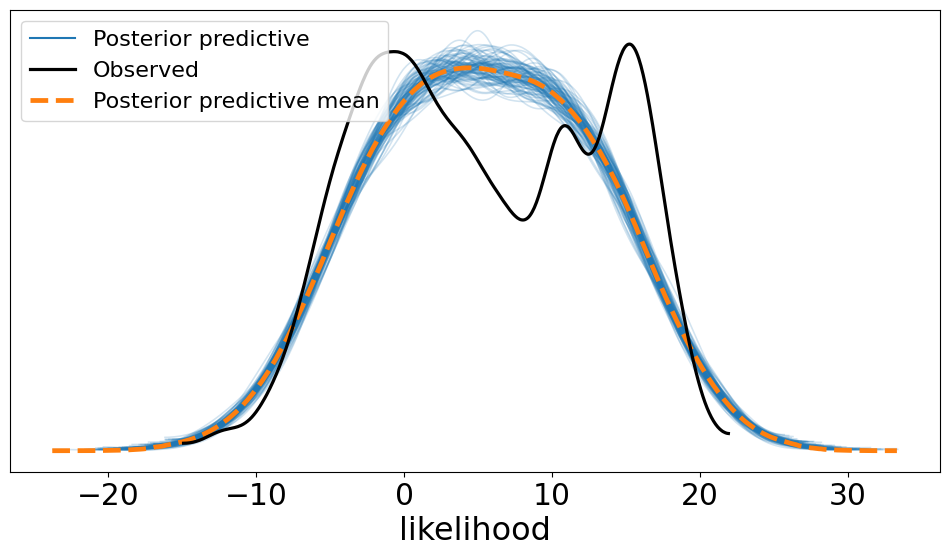

In [7]:
az.plot_ppc(idata_ar, num_pp_samples=100, figsize=(12, 6))

In [8]:
az.summary(idata_ar, var_names=["~ar"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],1.175,0.082,1.017,1.328,0.001,0.001,9434.0,5037.0,1.0
coefs[1],0.785,0.010,0.766,0.803,0.000,0.000,8648.0,5932.0,1.0
sigma,3.703,0.044,3.622,3.788,0.001,0.000,2739.0,3955.0,1.0


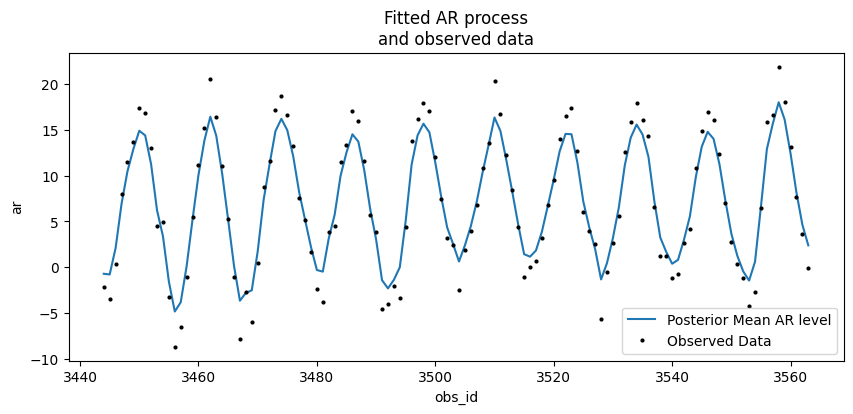

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
idata_ar.posterior.ar.mean(["chain", "draw"])[-10*12:].plot(ax=ax, label="Posterior Mean AR level")
ax.plot(t_data_train[-10 * 12:], train.values[-10 * 12:], "o", color="black", markersize=2, label="Observed Data")
ax.legend()
ax.set_title("Fitted AR process\nand observed data");

In [10]:
with AR:
    ## We need to have coords for the observations minus the lagged term to correctly centre the prediction step
    AR.add_coords({"obs_id_fut_1": np.concatenate([t_data_train[-1:], t_data_test])})
    AR.add_coords({"obs_id_fut": t_data_test})
    # condition on the learned values of the AR process
    # initialise the future AR process precisely at the last observed value in the AR process
    # using the special feature of the dirac delta distribution to be 0 everywhere else.
    ar1_fut = pm.AR(
        "ar1_fut",
        init_dist=pm.DiracDelta.dist(ar2[..., -1]),
        rho=coefs,
        sigma=sigma,
        constant=True,
        dims="obs_id_fut_1"
    )
    yhat_fut = pm.Normal("yhat_fut", mu=ar1_fut[1:], sigma=sigma, dims="obs_id_fut")
    # use the updated values and predict outcomes and probabilities:
    idata_preds = pm.sample_posterior_predictive(
        idata_ar, var_names=["likelihood", "yhat_fut"], predictions=True, random_seed=100
    )

Sampling: [ar1_fut, likelihood, yhat_fut]


Output()

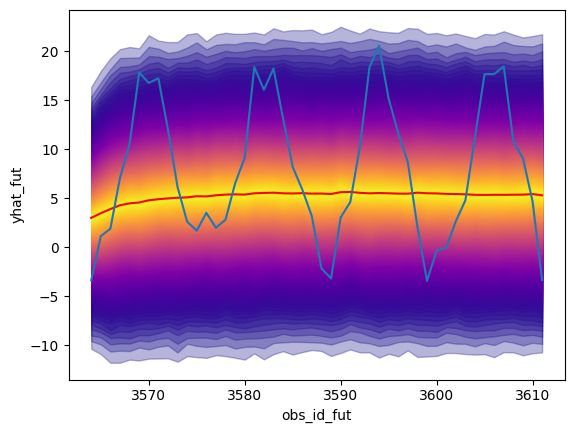

In [11]:
# idata_preds.predictions.yhat_fut[0].to_pandas().T.plot(alpha=0.01, color="y", legend=False)
idata_preds.predictions.yhat_fut.mean(['chain','draw']).plot(color="red")
plt.plot(t_data_test, test.values, label="Observed Data")
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))

palette = "plasma"
cmap = plt.get_cmap(palette)

for i,p in enumerate(percs[::-1]):
    upper = np.percentile(
        idata_preds.predictions.yhat_fut, p, axis=[0,1]
    )
    lower = np.percentile(
        idata_preds.predictions.yhat_fut, 100 - p, axis=[0,1]
    )
    color_val = colors[i]

    plt.fill_between(
        x=idata_preds.predictions.coords["obs_id_fut"].data,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.3,
    )
